Note: Much of this code was lifted from [the Conversation AI project](https://conversationai.github.io/). In this file, instead of using max DI I want to do each of the DIs against gay and basically plot a bunch of lines on the same axis, di of input and di of output but one line for white, one line for black, one line for jewish etc

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
import model_bias_analysis
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # feel free to comment this line out if not using retina screen

Read TSVs from file. These are the original data from *Conversation AI*.

* *grouped_annotations* takes the mean of all toxicity ratings of a comment.
* *joined_tox* joins *grouped_annotations* and *comments*.
* We also add a column *binary_tox* to the dataframe *joined_tox*. Here we assign a toxicity rating of 0 or 1 based on whether the mean toxicity rating is above or below 0.5 (or other value determined by threshold_binary_toxicity

Equation DI:
DI(t1,t2) = (probability that comment containing term t1 is labeled toxic) / (probability that comment containing term t2 is labelled toxic)
= a/b

a = # comments containing t1 AND toxic / # comments containing t1
= alpha/beta

In [2]:
def calculate_pairwise_di(df, madlibs_terms, colname):
    
    # We now calculate the DI for each pair for the training data.

    term_toxicity = np.zeros(len(madlibs_terms))

    # we temporarily put -1 in as a placeholder for stuff that has no exacmples of terms with that term.
    # non-binary is one
    for i in range(len(madlibs_terms)):
        try:
            term_toxicity[i] = float((df[(df[madlibs_terms[i]] == True) & (df[colname] == 1)].shape[0]))/  \
            float((df[df[madlibs_terms[i]] == True].shape[0]))
        except ZeroDivisionError:
            term_toxicity[i] = -1 

    return term_toxicity

# term_toxicity = calculate_pairwise_di(train_comments, madlibs_terms, 'binary_tox')
# print(term_toxicity)
# print(len(term_toxicity))


In [3]:
# This finds the max DI between all pairs of identity terms, which for one of our experiments,
# we're claiming is kind of the DI of all terms
# Possibly something we'll take out or come back to once we try more versions of our code. (Neha's working on this!)

def gay_ratio(term_toxicity, madlibs_terms):
    term_vs_gay = []
    top_indexes = ()
    j = 0 # This is the index of gay
    for i in range(len(madlibs_terms)):
        if (i==j or term_toxicity[i] == -1 or term_toxicity[j] == -1 or term_toxicity[j] == 0):
            term_vs_gay.append(1)
        else:
            term_vs_gay.append(term_toxicity[i]/ term_toxicity[j])          
    return term_vs_gay

In [4]:
# Calculate DI of each term vs gay on all of the perturbed training datasets
def find_gay_dis(df_comments, madlibs_terms, colname):
    
    term_vs_gay = []
    # So this is a series of DIs, one is t1/gay di, t2/gay di...

    # df_comments['newcol'] = list_perturbation[i]
    term_toxicity = calculate_pairwise_di(df_comments, madlibs_terms, colname)
    term_vs_gay = gay_ratio(term_toxicity, madlibs_terms)
        
    # This is the array of all of the max_dis, and the indexes of the madlibs_terms array that composed that max_di
    return term_vs_gay

In [5]:
def train_and_predict(train_comments, test_comments, i):

    clf = Pipeline([
        ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
        ('tfidf', TfidfTransformer(norm = 'l2')),
        ('clf', LogisticRegression()),
    ])

    clf = clf.fit(train_comments['comment'], train_comments['binary_tox'])
    auc = roc_auc_score(test_comments['binary_tox'], clf.predict_proba(test_comments['comment'])[:, 1])
    print('Test ROC AUC: %.3f' %auc)
    
    test_comments["predicted"+str(i)] = clf.predict(test_comments['comment'])
    
    return test_comments

That cell below takes a really long time to run

In [6]:
madlibs_terms = ['gay', 'homosexual', 'straight', 'black', 'white', 'american', 'jewish', 'old']
array_of_train_dis = []
array_of_test_dis = []
array_predicted_bin_tox = []
array_test_bin_tox = []
x_axis = []

#TODO: This code is really unnecessarily complicated, you could instead have a dictionary of dataframes and store all
for i in range(5,90,5):
# for i in range(30,40,5):
    x_axis.append(i)
    joined_tox = pd.read_csv('joined_tox' + str(i) + '.csv')
    train_comments = pd.read_csv('train_comments'+ str(i) + '.csv')
    test_comments = pd.read_csv('test_comments' + str(i) + '.csv')
    # madlibs_terms = model_bias_analysis.read_identity_terms('test_comments'+str(i)+'.csv')
    
    training_data_dis = find_gay_dis(train_comments, madlibs_terms, 'binary_tox')
    print(str(i), training_data_dis)
    array_of_train_dis.append((i,training_data_dis))
    
    test_comments = train_and_predict(train_comments, test_comments,str(i))
    
    temp_array = []
    temp_array = test_comments['predicted'+str(i)]
    array_predicted_bin_tox.append(temp_array)
    
    temp_array = []
    temp_array = test_comments['binary_tox']
    array_test_bin_tox.append(temp_array)
    
    test_data_dis = find_gay_dis(test_comments, madlibs_terms, 'predicted'+str(i))
    # print(str(i), test_data_dis)
    array_of_test_dis.append((i, test_data_dis))

5 [1, 0.998759305210918, 0.6342229199372056, 0.6726677577741407, 0.5878084179970973, 0.5196467426084731, 0.6921292164911654, 0.5339796945028812]
Test ROC AUC: 0.826
10 [1, 0.998759305210918, 0.6279434850863422, 0.6693944353518821, 0.5834542815674891, 0.5160629719697939, 0.6896305550597894, 0.5307783773895545]
Test ROC AUC: 0.826
15 [1, 1.0161290322580645, 0.4557823129251701, 0.4893617021276596, 0.419811320754717, 0.32127010537992234, 0.45204949729311683, 0.3384859294490686]
Test ROC AUC: 0.887
20 [1, 1.0182503872314634, 0.4567338417621746, 0.4868298316528228, 0.41753653444676414, 0.32194081541203073, 0.45028069886509503, 0.33641231360419427]
Test ROC AUC: 0.888
25 [1, 0.8842770133092712, 0.37676609105180536, 0.4106531766106234, 0.332497690988257, 0.24977795360490865, 0.35435562117696684, 0.27395513721316334]
Test ROC AUC: 0.917
30 [1, 0.8863430810973771, 0.37764638565706665, 0.4076357128653808, 0.3315111973196967, 0.2503615469544529, 0.3551835548713056, 0.2745952193094558]
Test ROC AUC

In [7]:
test_comments['temp'] = array_test_bin_tox[10]
test_comments['temp'].value_counts()
#test_comments[(test_comments['gay'] == True) & (test_comments['temp'] == 1)].shape[0]

0    28829
1     3037
Name: temp, dtype: int64

In [8]:
print(array_of_test_dis)
# so array[i] refers to a [30, [1, #, #, #, #]]
# array[i][1] pulls out just the array corresponding to percentile i
# and arraay[i][1][j] pulls out the value corresponding to percentile i and term j

[(5, [1, 0.9066645856094896, 0.64340440696086, 0.596112195513249, 0.5384501670460928, 0.47287608446554263, 0.7332705365202716, 0.48447693246350965]), (10, [1, 0.9127906976744186, 0.6102009088734752, 0.6001399806180683, 0.5374151684724372, 0.47607119314436386, 0.7382250671724356, 0.4747684747684748]), (15, [1, 0.8261755219826854, 0.42594147664879534, 0.3606886323319859, 0.3079520241808418, 0.23199216663699485, 0.3283817817048704, 0.23440610484406105]), (20, [1, 0.8261755219826854, 0.42594147664879534, 0.35612295344170763, 0.3079520241808418, 0.23199216663699485, 0.3216801126904853, 0.2303991628809147]), (25, [1, 0.8425760286225403, 0.3087512291052114, 0.28869138829298197, 0.24236605293874017, 0.18000833854492393, 0.23541760383865648, 0.18063773833004604]), (30, [1, 0.8425760286225403, 0.3087512291052114, 0.27799911465250116, 0.24236605293874017, 0.17018970189701899, 0.24326485729994501, 0.18063773833004604]), (35, [1, 0.7577885037297061, 0.22282517949574224, 0.23603698413891605, 0.21531

Below is the test dataset DIs, gay

In [9]:
# ## The chosen one

# y_axis_t1 = []
# y_axis_t2 = []
# y_axis_t3 = []
# y_axis_t4 = []
# y_axis_t5 = []
# y_axis_t6 = []
# y_axis_t7 = []
# plt.figure(figsize=(12, 8))


# for i in range(len(array_of_test_dis)):
#     y_axis_t1.append(array_of_test_dis[i][1][1])
#     y_axis_t2.append(array_of_test_dis[i][1][2])
#     y_axis_t3.append(array_of_test_dis[i][1][3])
#     y_axis_t4.append(array_of_test_dis[i][1][4])
#     y_axis_t5.append(array_of_test_dis[i][1][5])
#     y_axis_t6.append(array_of_test_dis[i][1][6])
#     y_axis_t7.append(array_of_test_dis[i][1][7])
# line1, = plt.plot(x_axis, y_axis_t1, "ro-", label=madlibs_terms[1])
# line2, = plt.plot(x_axis, y_axis_t2, "o-", color='orange', label=madlibs_terms[2])
# line3, = plt.plot(x_axis, y_axis_t3, "o-", color='gold', label=madlibs_terms[3])
# line4, = plt.plot(x_axis, y_axis_t4, "go-", label=madlibs_terms[4])
# line5, = plt.plot(x_axis, y_axis_t5, "o-", color='purple', label=madlibs_terms[5])
# line6, = plt.plot(x_axis, y_axis_t6, "co-", label=madlibs_terms[6])
# line7, = plt.plot(x_axis, y_axis_t7, "bo-", label=madlibs_terms[7])
# plt.title("Impact of aggregate threshold value on DI of (term, 'gay') on classified data", fontsize=20)
# plt.xlabel("Threshold value for aggregating human ratings of training data", fontsize=18)
# plt.ylabel("Test dataset DI (term, 'gay')", fontsize=20)
# plt.xlim([20, 100])
# plt.ylim([-0.1, 1])
# plt.legend(handles=[line1,line2,line3,line4,line6,line7,line5])
# plt.savefig('pothreshold-graph2.png', bbox_inches='tight')

# # Impact of aggregate threshold on DI of (term, 'gay') between training and test")
# # plt.xlabel("Threshold of aggregate human ratings for training data, or cautiousness in classifying as toxic")
# # plt.ylabel("Training DI (term,'gay') - Test DI (term,'gay')")

# # x = np.array(x_axis).reshape(-1, 1)
# # reg1 = linear_model.LinearRegression()
# # reg1.fit(x, y_axis_t1)
# # y_pred1 = reg1.predict(x)
# # plt.plot(x, y_pred1, color='r', linewidth=1)

# # reg2 = linear_model.LinearRegression()
# # reg2.fit(x, y_axis_t5)
# # y_pred2 = reg2.predict(x)
# # plt.plot(x, y_pred2, color='g', linewidth=1)


Now this is the inverse of the above graph, so it's still test dataset DI vs gay but with inverse of the y axis

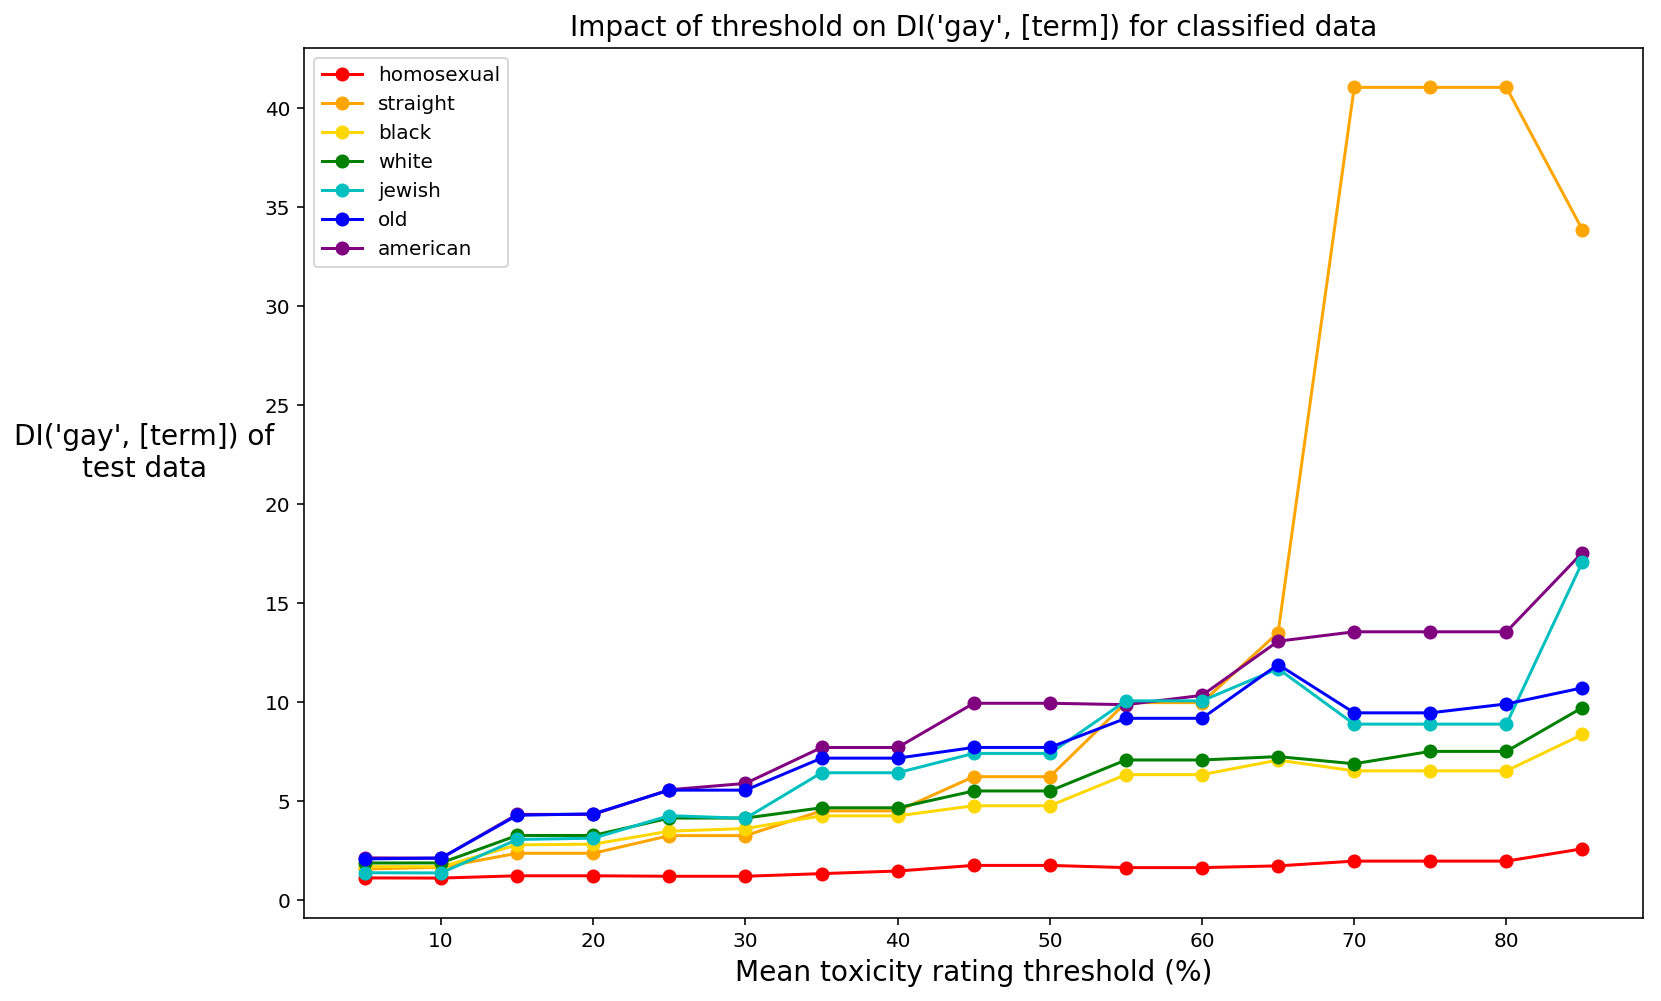

In [10]:
## The chosen one

y_axis_t1 = []
y_axis_t2 = []
y_axis_t3 = []
y_axis_t4 = []
y_axis_t5 = []
y_axis_t6 = []
y_axis_t7 = []
plt.figure(figsize=(12, 8))


for i in range(len(array_of_test_dis)):
    y_axis_t1.append(1/array_of_test_dis[i][1][1])
    y_axis_t2.append(1/array_of_test_dis[i][1][2])
    y_axis_t3.append(1/array_of_test_dis[i][1][3])
    y_axis_t4.append(1/array_of_test_dis[i][1][4])
    y_axis_t5.append(1/array_of_test_dis[i][1][5])
    y_axis_t6.append(1/array_of_test_dis[i][1][6])
    y_axis_t7.append(1/array_of_test_dis[i][1][7])
line1, = plt.plot(x_axis, y_axis_t1, "ro-", label=madlibs_terms[1])
line2, = plt.plot(x_axis, y_axis_t2, "o-", color='orange', label=madlibs_terms[2])
line3, = plt.plot(x_axis, y_axis_t3, "o-", color='gold', label=madlibs_terms[3])
line4, = plt.plot(x_axis, y_axis_t4, "go-", label=madlibs_terms[4])
line5, = plt.plot(x_axis, y_axis_t5, "o-", color='purple', label=madlibs_terms[5])
line6, = plt.plot(x_axis, y_axis_t6, "co-", label=madlibs_terms[6])
line7, = plt.plot(x_axis, y_axis_t7, "bo-", label=madlibs_terms[7])

plt.title("Impact of threshold on DI('gay', [term]) for classified data", fontsize=14)
plt.xlabel("Mean toxicity rating threshold (%)", fontsize=14)
ylabel = "DI('gay', [term]) of test data"

from textwrap import wrap

ylabel_wrapped = '\n'.join(wrap(ylabel, 20))
plt.ylabel(ylabel_wrapped, rotation=0, labelpad=60, fontsize=14)
# plt.xlim([20, 100])
# plt.ylim([-0.1, 1])
plt.legend(handles=[line1,line2,line3,line4,line6,line7,line5])
# print("*", y_axis_tr1)

plt.savefig('threshold-di-gay-test.png', bbox_inches='tight')

Below is the training dataset vs gay

Now this is the inverse of the above graph, so still training dataset but 1/y axis

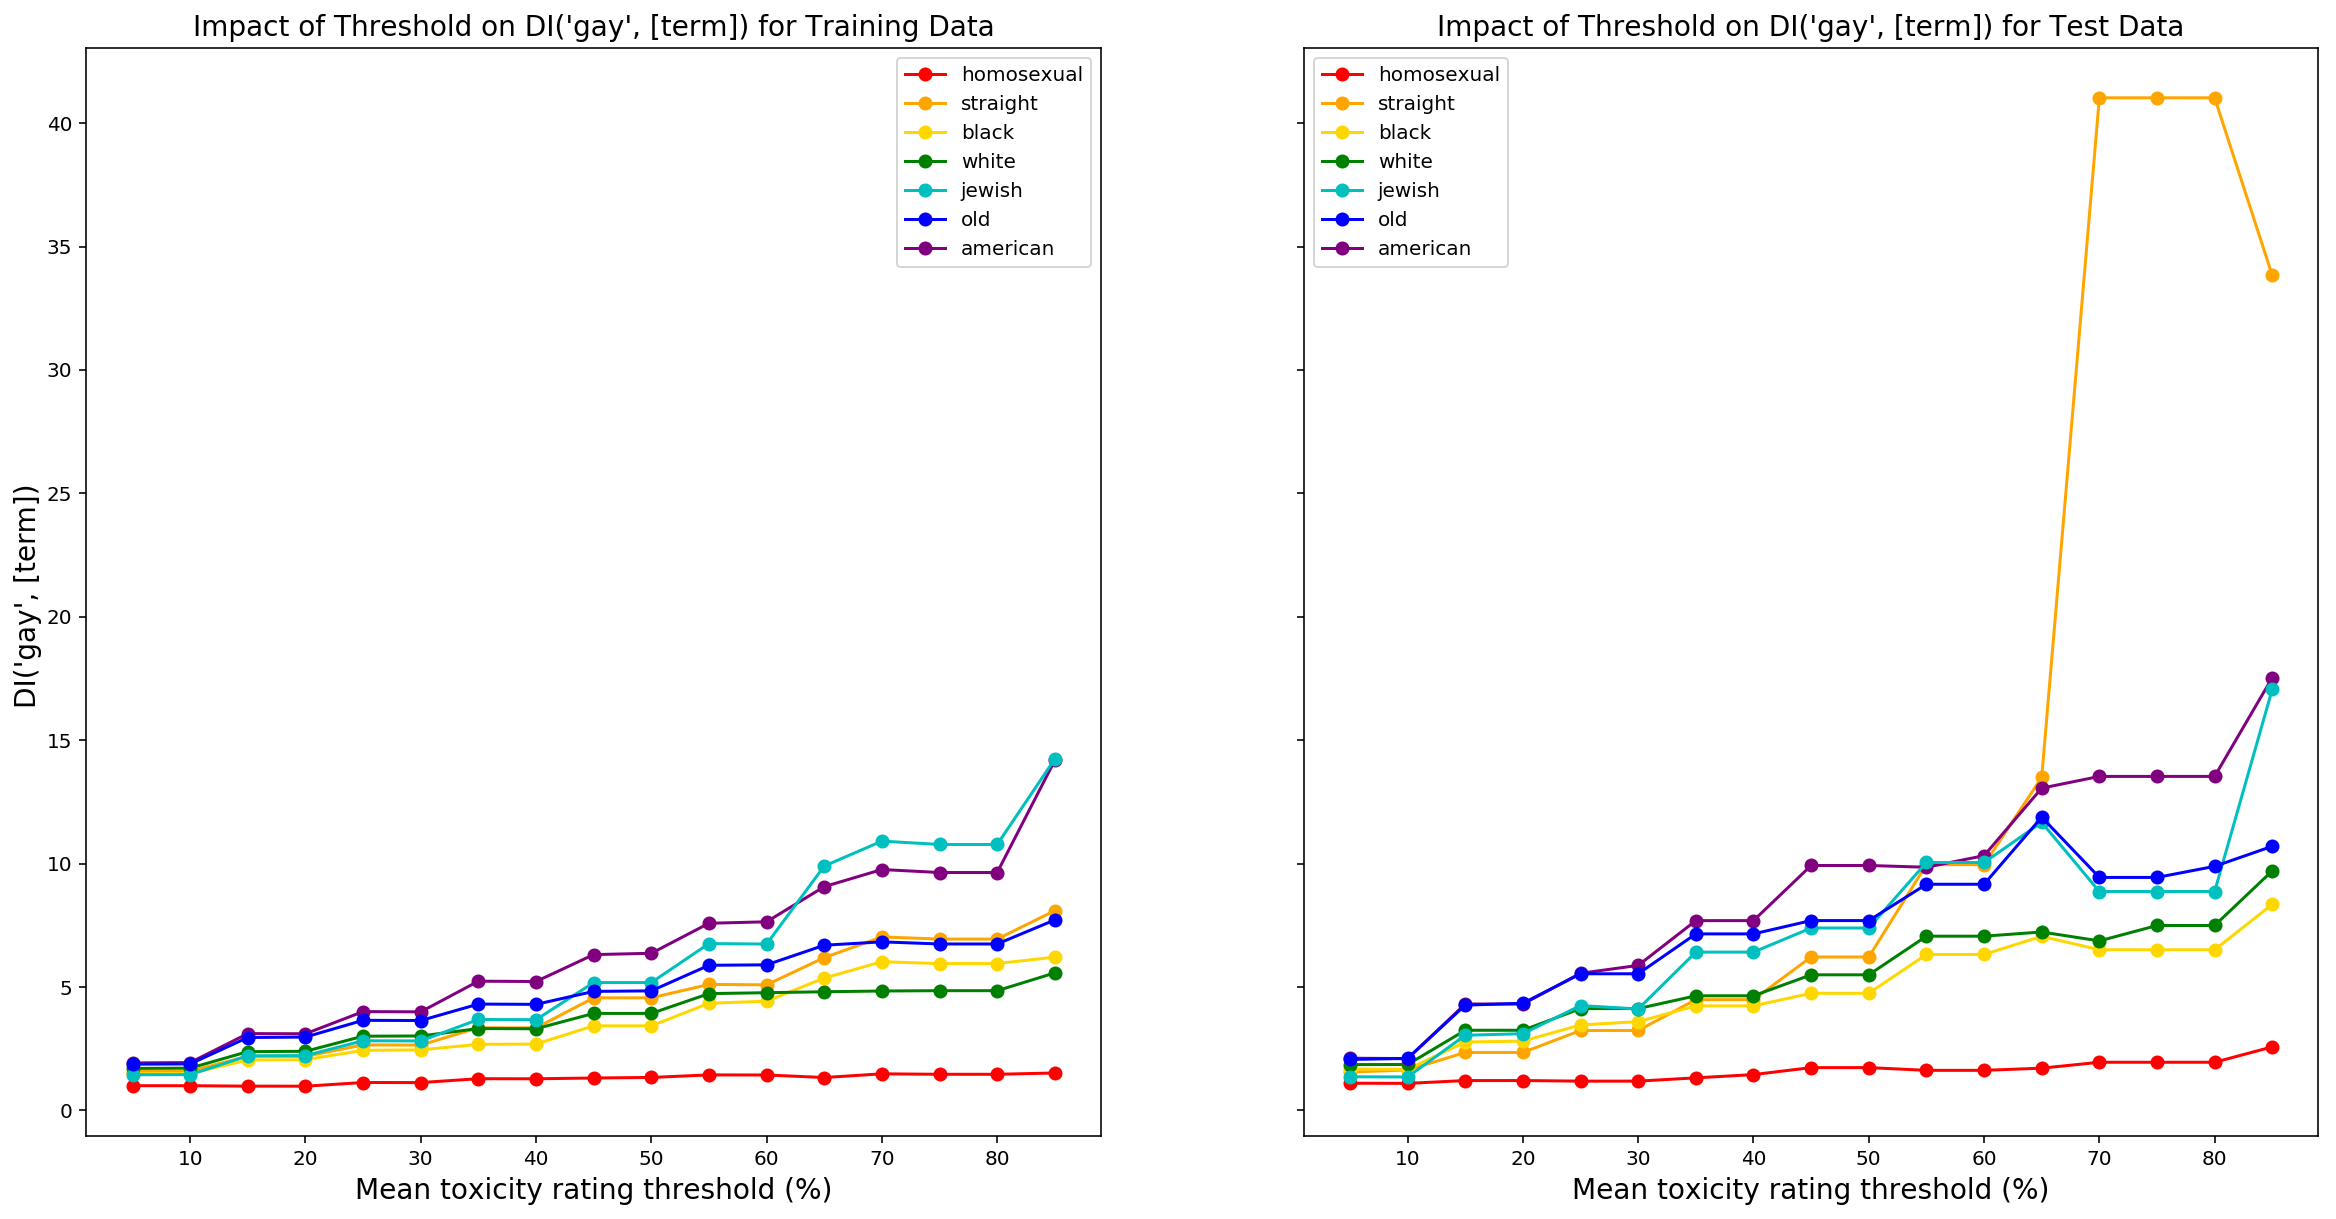

In [58]:
# Two subplots, unpack the axes array immediately
# ax = fig.add_subplot(111)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 10))
line1, = ax1.plot(x_axis, y_axis_tr1, "ro-", label=madlibs_terms[1])
line2, = ax1.plot(x_axis, y_axis_tr2, "o-", color='orange', label=madlibs_terms[2])
line3, = ax1.plot(x_axis, y_axis_tr3, "o-", color='gold', label=madlibs_terms[3])
line4, = ax1.plot(x_axis, y_axis_tr4, "go-", label=madlibs_terms[4])
line5, = ax1.plot(x_axis, y_axis_tr5, "o-", color='purple', label=madlibs_terms[5])
line6, = ax1.plot(x_axis, y_axis_tr6, "co-", label=madlibs_terms[6])
line7, = ax1.plot(x_axis, y_axis_tr7, "bo-", label=madlibs_terms[7])
ax1.set_title("Impact of Threshold on DI('gay', [term]) for Training Data", fontsize=14)
ax1.legend(handles=[line1,line2,line3,line4,line6,line7,line5])
ax1.set_xlabel("Mean toxicity rating threshold (%)", fontsize=14)
# ax1.plot(x, y)
# ax1.set_title('Sharing Y axis')
# ax2.scatter(x, y)

line1, = ax2.plot(x_axis, y_axis_t1, "ro-", label=madlibs_terms[1])
line2, = ax2.plot(x_axis, y_axis_t2, "o-", color='orange', label=madlibs_terms[2])
line3, = ax2.plot(x_axis, y_axis_t3, "o-", color='gold', label=madlibs_terms[3])
line4, = ax2.plot(x_axis, y_axis_t4, "go-", label=madlibs_terms[4])
line5, = ax2.plot(x_axis, y_axis_t5, "o-", color='purple', label=madlibs_terms[5])
line6, = ax2.plot(x_axis, y_axis_t6, "co-", label=madlibs_terms[6])
line7, = ax2.plot(x_axis, y_axis_t7, "bo-", label=madlibs_terms[7])
ax2.set_title("Impact of Threshold on DI('gay', [term]) for Test Data", fontsize=14)
ax2.legend(handles=[line1,line2,line3,line4,line6,line7,line5])
ax2.set_xlabel("Mean toxicity rating threshold (%)", fontsize=14)
# ylabel = "DI('gay', [term]) of test data"
# ax1.set_ylabel = "DI('gay', [term])"
# ax2.set_ylabel = "DI('gay', [term])"
f.text(0.1, 0.5, "DI('gay', [term])", va='center', rotation='vertical',  fontsize=14)
plt.savefig('Impact_Threshold_DI.png', bbox_inches='tight')

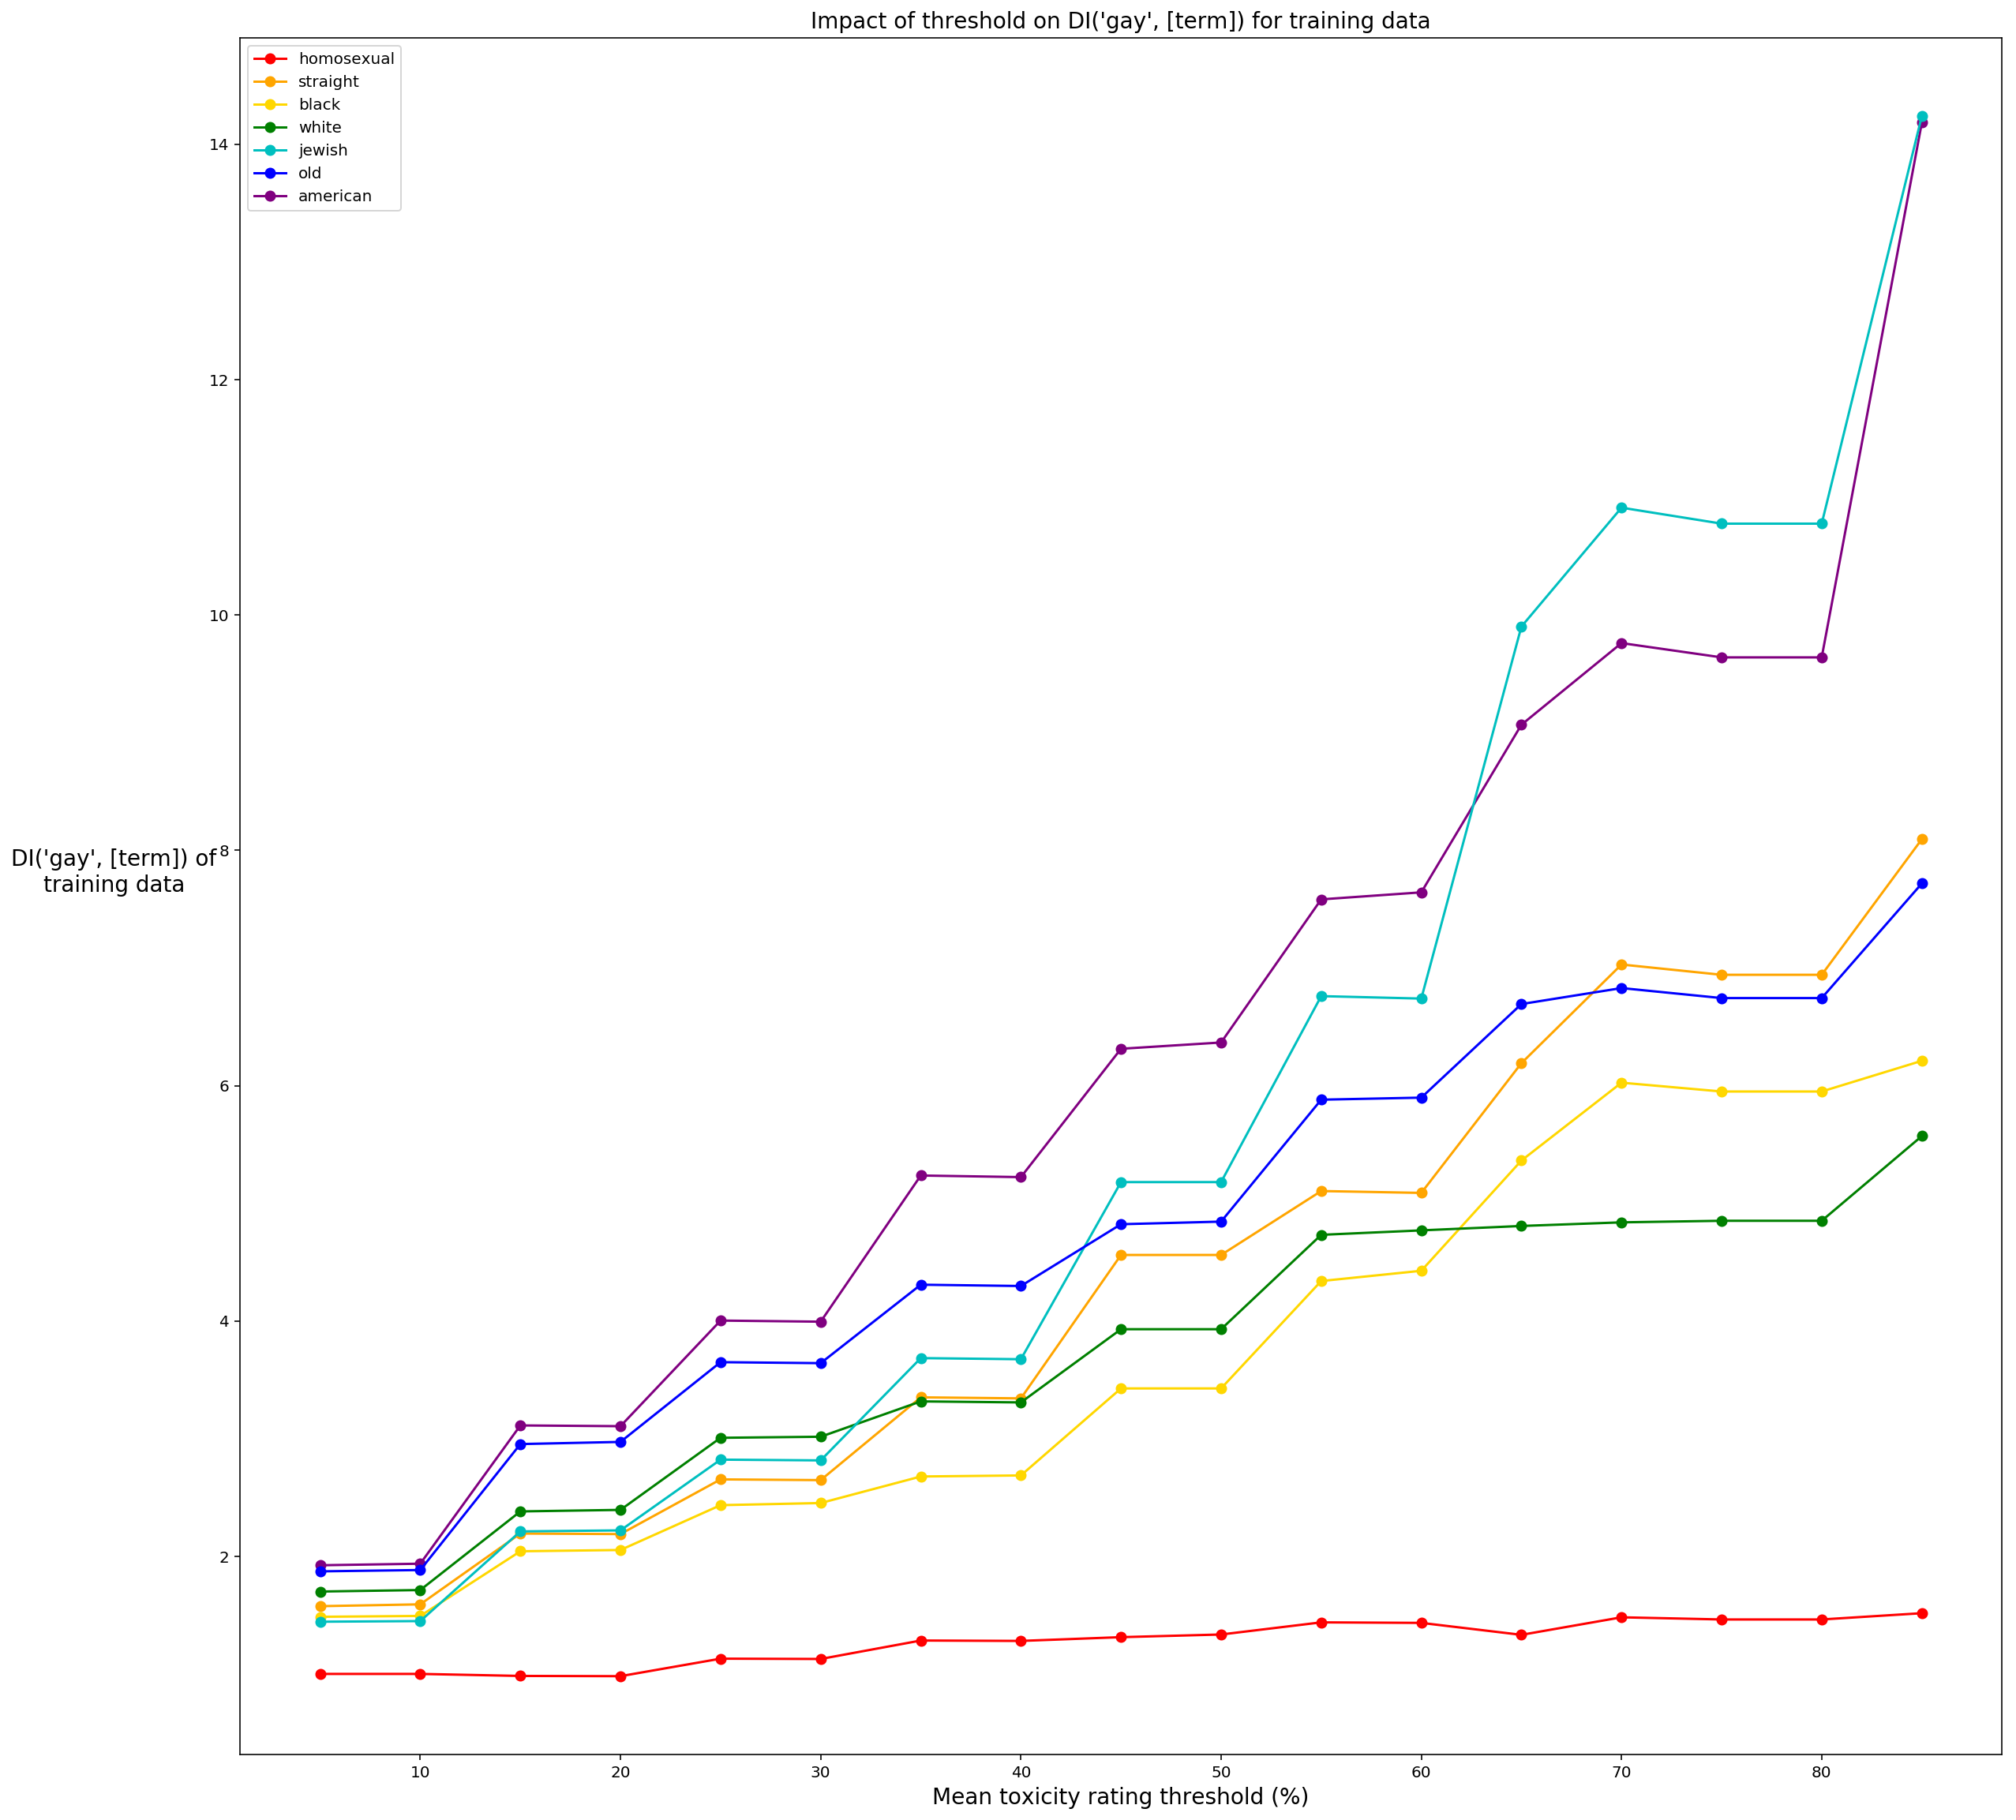

In [30]:
y_axis_tr1 = []
y_axis_tr2 = []
y_axis_tr3 = []
y_axis_tr4 = []
y_axis_tr5 = []
y_axis_tr6 = []
y_axis_tr7 = []

plt.figure(figsize=(12, 8))



for i in range(len(array_of_train_dis)):
    y_axis_tr1.append(1/array_of_train_dis[i][1][1])
    y_axis_tr2.append(1/array_of_train_dis[i][1][2])
    y_axis_tr3.append(1/array_of_train_dis[i][1][3])
    y_axis_tr4.append(1/array_of_train_dis[i][1][4])
    y_axis_tr5.append(1/array_of_train_dis[i][1][5])
    y_axis_tr6.append(1/array_of_train_dis[i][1][6])
    y_axis_tr7.append(1/array_of_train_dis[i][1][7])

# print("**", y_axis_tr1)
line1, = plt.plot(x_axis, y_axis_tr1, "ro-", label=madlibs_terms[1])
line2, = plt.plot(x_axis, y_axis_tr2, "o-", color='orange', label=madlibs_terms[2])
line3, = plt.plot(x_axis, y_axis_tr3, "o-", color='gold', label=madlibs_terms[3])
line4, = plt.plot(x_axis, y_axis_tr4, "go-", label=madlibs_terms[4])
line5, = plt.plot(x_axis, y_axis_tr5, "o-", color='purple', label=madlibs_terms[5])
line6, = plt.plot(x_axis, y_axis_tr6, "co-", label=madlibs_terms[6])
line7, = plt.plot(x_axis, y_axis_tr7, "bo-", label=madlibs_terms[7])
    
plt.title("Impact of threshold on DI('gay', [term]) for training data", fontsize=14)
plt.xlabel("Mean toxicity rating threshold (%)", fontsize=14)
ylabel = "DI('gay', [term]) of training data"

from textwrap import wrap

ylabel_wrapped = '\n'.join(wrap(ylabel, 20))
plt.ylabel(ylabel_wrapped, rotation=0, labelpad=60, fontsize=14)
# plt.xlim([20, 100])
# plt.ylim([-0.1, 1])
plt.legend(handles=[line1,line2,line3,line4,line6,line7,line5])
# print("*", y_axis_tr1)
plt.savefig('threshold-di-gay-train.png', bbox_inches='tight')

In [11]:
# y_axis_tr1 = []
# y_axis_tr2 = []
# y_axis_tr3 = []
# y_axis_tr4 = []
# y_axis_tr5 = []
# y_axis_tr6 = []
# y_axis_tr7 = []

# plt.figure(figsize=(12, 8))



# for i in range(len(array_of_train_dis)):
#     y_axis_tr1.append(array_of_train_dis[i][1][1])
#     y_axis_tr2.append(array_of_train_dis[i][1][2])
#     y_axis_tr3.append(array_of_train_dis[i][1][3])
#     y_axis_tr4.append(array_of_train_dis[i][1][4])
#     y_axis_tr5.append(array_of_train_dis[i][1][5])
#     y_axis_tr6.append(array_of_train_dis[i][1][6])
#     y_axis_tr7.append(array_of_train_dis[i][1][7])

# print("**", y_axis_tr1)
# line1, = plt.plot(x_axis, y_axis_tr1, "ro-", label=madlibs_terms[1])
# line2, = plt.plot(x_axis, y_axis_tr2, "o-", color='orange', label=madlibs_terms[2])
# line3, = plt.plot(x_axis, y_axis_tr3, "o-", color='gold', label=madlibs_terms[3])
# line4, = plt.plot(x_axis, y_axis_tr4, "go-", label=madlibs_terms[4])
# line5, = plt.plot(x_axis, y_axis_tr5, "o-", color='purple', label=madlibs_terms[5])
# line6, = plt.plot(x_axis, y_axis_tr6, "co-", label=madlibs_terms[6])
# line7, = plt.plot(x_axis, y_axis_tr7, "bo-", label=madlibs_terms[7])
    
# plt.title("Impact of mean toxicity rating threshold on DI of ('gay', term) on training data", fontsize=20)
# plt.xlabel("Threshold training data", fontsize=18)
# plt.ylabel("Test dataset DI ('gay', term)", fontsize=20)
# plt.xlim([20, 100])
# plt.ylim([-0.1, 1])
# plt.legend(handles=[line1,line2,line3,line4,line6,line7,line5])
# print("*", y_axis_tr1)

This is the graph of the difference between test and training (not the inverses) but its messy messy 

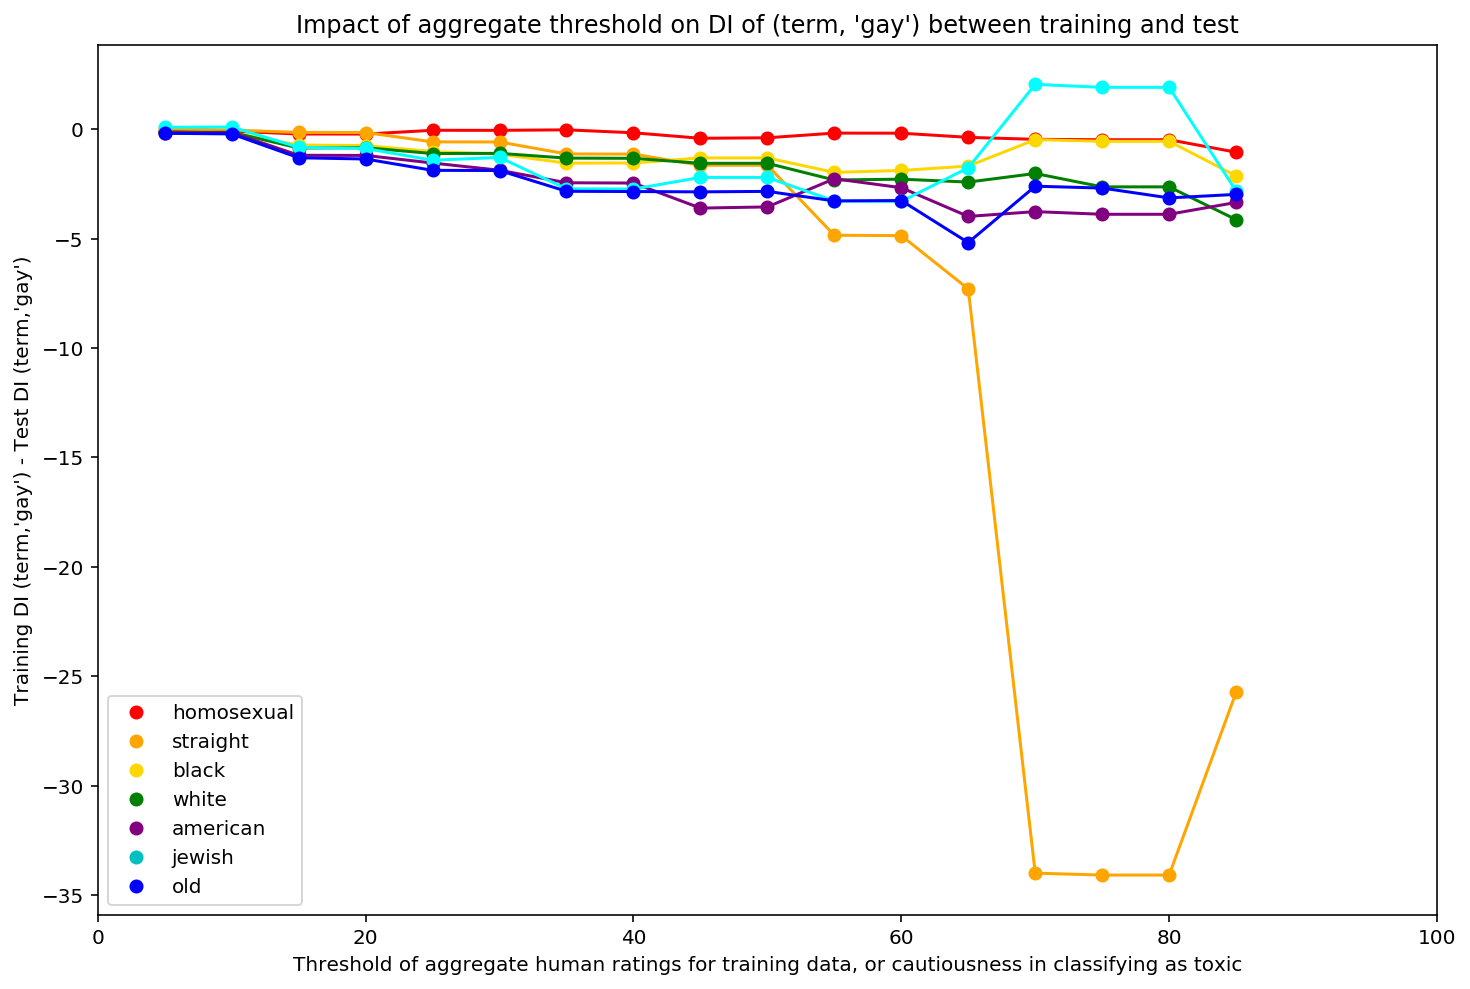

In [23]:
# # A graph of the difference between test and training DI on y axis and x axis of threshold
# # for t1/gay
# # madlibs_terms = ['gay', 'homosexual', 'straight', 'black', 'white', 'american', 'jewish', 'old']

# # A graph of the difference between test and training DI on y axis and x axis of threshold
# # for t1/gay
# # Currently this is train-test

# # x_axis = []
# # y_axis_t1 = []
# plt.figure(figsize=(12, 8))

# array_ys = []
# array_training_ys = [y_axis_tr1, y_axis_tr2, y_axis_tr3, y_axis_tr4, y_axis_tr5, y_axis_tr6, y_axis_tr7]
# array_test_ys = [y_axis_t1, y_axis_t2, y_axis_t3, y_axis_t4, y_axis_t5, y_axis_t6, y_axis_t7]

# for i in range(len(array_training_ys)):
#     array_ys.append(np.subtract(array_training_ys[i], array_test_ys[i]))



# d={}
# colors = ["red", "orange", "gold", "green", "purple", "cyan", "blue"]
# for i in range(len(array_ys)):
#     d["line{}.format(i)"], = plt.plot(x_axis, array_ys[i], "o-", color=colors[i], label=madlibs_terms[i+1])

# plt.xlim([0, 100])
# # plt.ylim([0, 50])
# plt.title("Impact of aggregate threshold on DI of (term, 'gay') between training and test")
# plt.xlabel("Threshold of aggregate human ratings for training data, or cautiousness in classifying as toxic")
# plt.ylabel("Training DI (term,'gay') - Test DI (term,'gay')")
# #plt.legend(handles=[d["line{}.format(x)"] for x in range(len(array_ys))]) # Thought this line might work and it doesnt
# plt.legend(handles=[line1, line2, line3, line4, line5, line6, line7])

# plt.savefig('pothreshold-graph.png', bbox_inches='tight')

The inverse of diff.

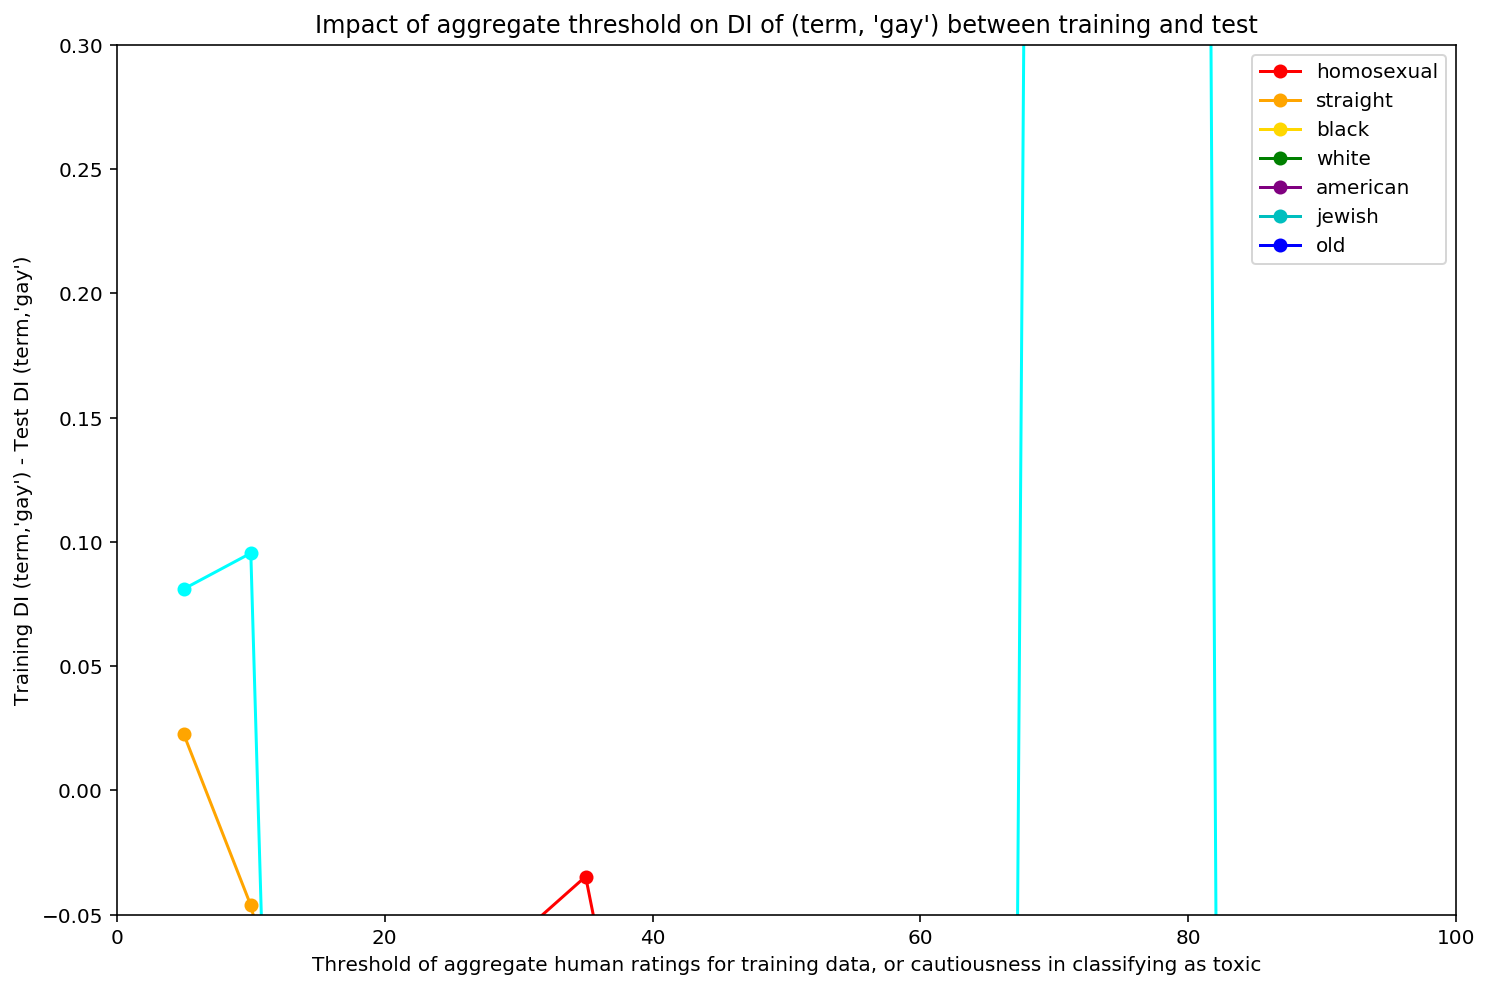

In [14]:
# A graph of the difference between test and training DI on y axis and x axis of threshold
# for t1/gay
# madlibs_terms = ['gay', 'homosexual', 'straight', 'black', 'white', 'american', 'jewish', 'old']

# A graph of the difference between test and training DI on y axis and x axis of threshold
# for t1/gay
# Currently this is train-test

# x_axis = []
# y_axis_t1 = []
plt.figure(figsize=(12, 8))

array_ys = []
array_training_ys = [y_axis_tr1, y_axis_tr2, y_axis_tr3, y_axis_tr4, y_axis_tr5, y_axis_tr6, y_axis_tr7]
array_test_ys = [y_axis_t1, y_axis_t2, y_axis_t3, y_axis_t4, y_axis_t5, y_axis_t6, y_axis_t7]

for i in range(len(array_training_ys)):
    array_ys.append(np.subtract(array_training_ys[i], array_test_ys[i]))



d={}
colors = ["red", "orange", "gold", "green", "purple", "cyan", "blue"]
for i in range(len(array_ys)):
    d["line{}.format(i)"], = plt.plot(x_axis, array_ys[i], "o-", color=colors[i], label=madlibs_terms[i+1])

plt.xlim([0, 100])
plt.ylim([-0.05, .3])
plt.title("Impact of aggregate threshold on DI of (term, 'gay') between training and test")
plt.xlabel("Threshold of aggregate human ratings for training data, or cautiousness in classifying as toxic")
plt.ylabel("Training DI (term,'gay') - Test DI (term,'gay')")
#plt.legend(handles=[d["line{}.format(x)"] for x in range(len(array_ys))]) # Thought this line might work and it doesnt
plt.legend(handles=[line1, line2, line3, line4, line5, line6, line7])

plt.savefig('pothreshold-graph.png', bbox_inches='tight')

In [15]:
#test_comments['temp'] = array_predicted_bin_tox[0]
#test_comments.head()

x_axis:  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
num_comments_gay 157
num_gay_and_toxic 149
num_gay_and_toxic 148
num_gay_and_toxic 137
num_gay_and_toxic 137
num_gay_and_toxic 117
num_gay_and_toxic 117
num_gay_and_toxic 106
num_gay_and_toxic 106
num_gay_and_toxic 95
num_gay_and_toxic 95
num_gay_and_toxic 83
num_gay_and_toxic 83
num_gay_and_toxic 75
num_gay_and_toxic 57
num_gay_and_toxic 57
num_gay_and_toxic 57
num_gay_and_toxic 47


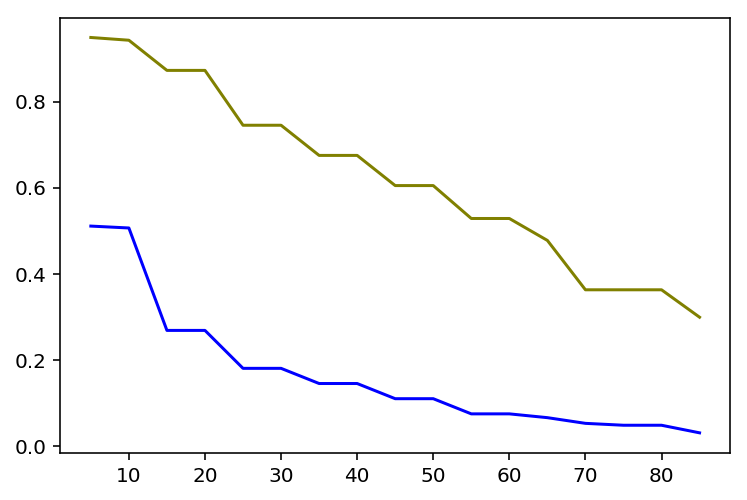

In [16]:
# Curious about the literal probability that gay (and white) sis classified as toxic changing as threshold changes
print("x_axis: ", x_axis)
num_of_comments_gay = test_comments[test_comments['gay'] == True].shape[0]
num_of_comments_white = test_comments[test_comments['white'] == True].shape[0]
print("num_comments_gay", num_of_comments_gay)
gay_toxic_prob = []
num_gay_and_toxic = []
white_toxic_prob = []
for i in range(len(array_predicted_bin_tox)):
    test_comments['temp'] = array_predicted_bin_tox[i]
    test_comments.head()
    num_gay_and_toxic = test_comments[(test_comments['gay'] == True) & (test_comments['temp'] == 1)].shape[0]
    num_white_and_toxic = test_comments[(test_comments['white'] == True) & (test_comments['temp'] == 1)].shape[0]
    print("num_gay_and_toxic", num_gay_and_toxic)
    gay_toxic_prob.append(num_gay_and_toxic/num_of_comments_gay)
    white_toxic_prob.append(num_white_and_toxic/num_of_comments_white)
plt.plot(x_axis, gay_toxic_prob, color='olive')
plt.plot(x_axis, white_toxic_prob, color='blue')

In [17]:
# Also curious about the FPR/TPR of gay as threshold changes
# fpr = false positive / false positive + true negative = false positive / total negative

# This requires an assumption about what ground truth is. What should it be? The 50% threshold val? The x% threshold val? 
# We are assuming it is the same as the threshold

#for i in range(len(array_test_bin_tox)):
    # the "true" value is in array_test_bin_tox
    # the predicted value is in array_predicted_bin_tox
    

#test_comments['temp'] = array_test_bin_tox[10]
#test_comments['temp'].value_counts()

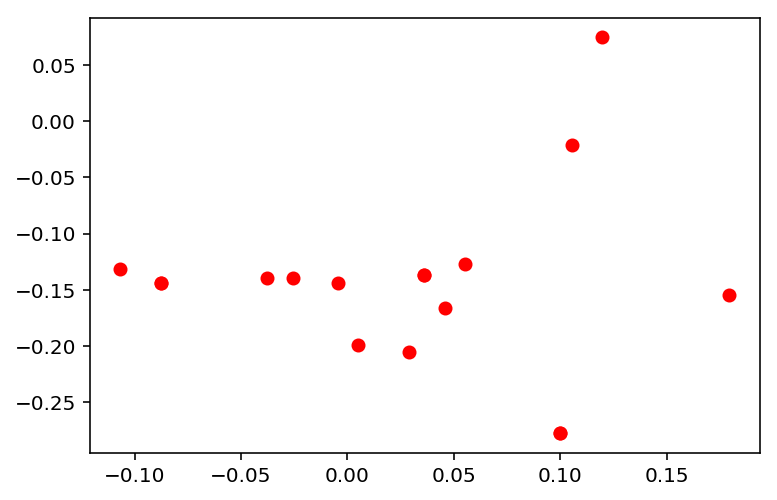

In [18]:
# Try the predictive parity equation here. -_- 
#for i in range(len(array_test_bin_tox)):
    # doing it for gay and white
    # p(predicted = 1 given "true" = 1 and comment about gay)
    # = (predicted = 1 and true = 1 and comment about gay)/(predicted =1 and comment gay)
    
i = 4
# thats the index for 50
arrayX = []
arrayY = []
for i in range(len(array_test_bin_tox)):
    test_comments['tempTrue'] = array_test_bin_tox[i]
    test_comments['tempPred'] = array_predicted_bin_tox[i]
    gay_predicted1_true1 = test_comments[(test_comments['gay'] == True) & \
                                         (test_comments['tempTrue'] == 1) & \
                                         (test_comments['tempPred'] == 1)].shape[0]
    gay_pred1 = test_comments[(test_comments['gay'] == True) & (test_comments['tempPred'] == 1)].shape[0]

    white_predicted1_true1 = test_comments[(test_comments['white'] == True) & \
                                         (test_comments['tempTrue'] == 1) & \
                                         (test_comments['tempPred'] == 1)].shape[0]
    white_pred1 = test_comments[(test_comments['white'] == True) & (test_comments['tempPred'] == 1)].shape[0]

    gay_pred0_true0 = test_comments[(test_comments['gay'] == True) & \
                                         (test_comments['tempTrue'] == 0) & \
                                         (test_comments['tempPred'] == 0)].shape[0]

    gay_pred0 = test_comments[(test_comments['gay'] == True) & (test_comments['tempPred'] == 0)].shape[0]

    white_predicted0_true0 = test_comments[(test_comments['white'] == True) & \
                                         (test_comments['tempTrue'] == 0) & \
                                         (test_comments['tempPred'] == 0)].shape[0]
    white_pred0 = test_comments[(test_comments['white'] == True) & (test_comments['tempPred'] == 0)].shape[0]

    #print("**", i)
    #print((gay_predicted1_true1/gay_pred1))
    #print((white_predicted1_true1/white_pred1))
    #print((gay_pred0_true0/gay_pred0))
    #print((white_predicted0_true0/white_pred0))
    diffPred1True1 = (gay_predicted1_true1/gay_pred1) - (white_predicted1_true1/white_pred1)
    diffPred0True0 = (gay_pred0_true0/gay_pred0) - (white_predicted0_true0/white_pred0)
    #print(diffPred1True1, diffPred0True0)
    
    arrayX.append(diffPred1True1)
    arrayY.append(diffPred0True0)
    
plt.plot(arrayX, arrayY, "ro")

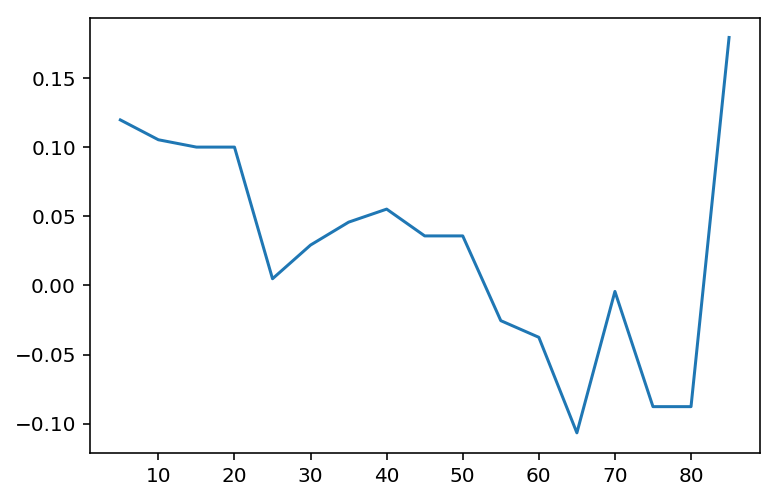

In [19]:
plt.plot(x_axis, arrayX)

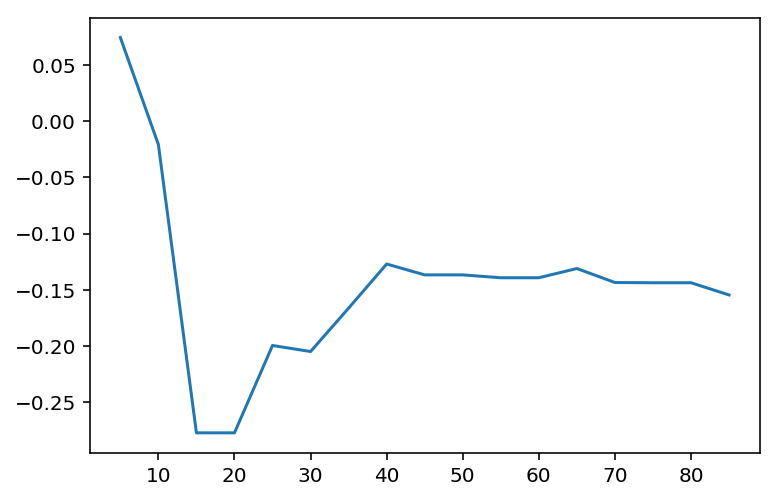

In [20]:
plt.plot(x_axis, arrayY)

This one below we're not using.

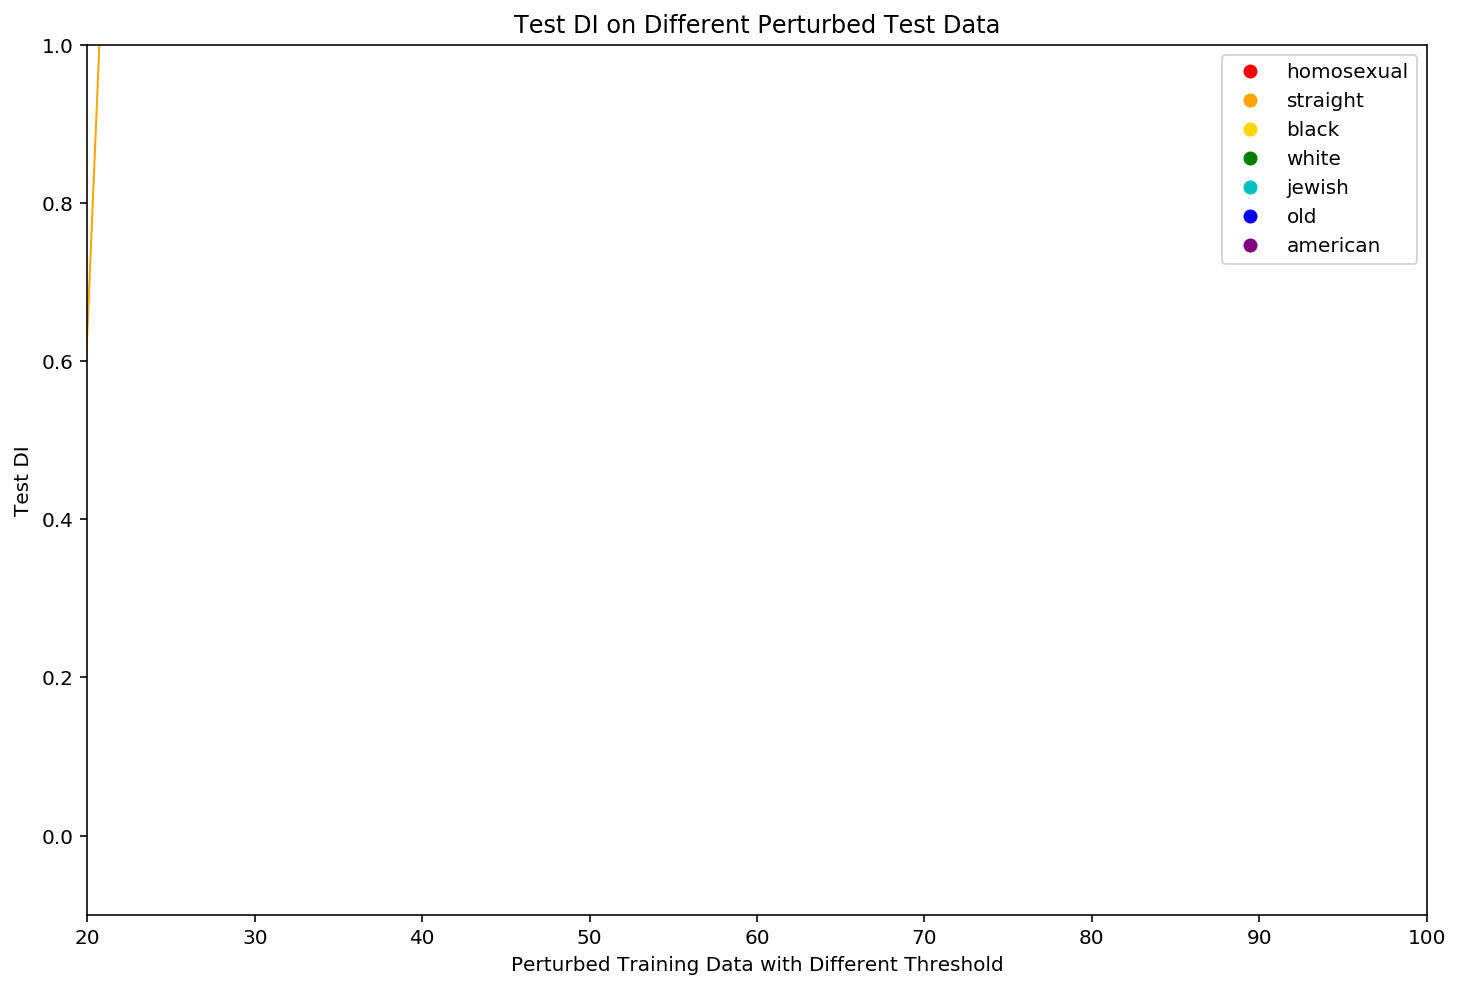

In [21]:
plt.figure(figsize=(12, 8))

line1, = plt.plot(x_axis, y_axis_t1, "ro", label=madlibs_terms[1])
line2, = plt.plot(x_axis, y_axis_t2, "o", color='orange', label=madlibs_terms[2])
line3, = plt.plot(x_axis, y_axis_t3, "o", color='gold', label=madlibs_terms[3])
line4, = plt.plot(x_axis, y_axis_t4, "go", label=madlibs_terms[4])
line5, = plt.plot(x_axis, y_axis_t5, "o", color='purple', label=madlibs_terms[5])
line6, = plt.plot(x_axis, y_axis_t6, "co", label=madlibs_terms[6])
line7, = plt.plot(x_axis, y_axis_t7, "bo", label=madlibs_terms[7])
plt.title("Test DI on Different Perturbed Test Data")
plt.xlabel("Perturbed Training Data with Different Threshold")
plt.ylabel("Test DI")
plt.xlim([20, 100])
plt.ylim([-0.1, 1])
plt.legend(handles=[line1,line2,line3,line4,line6,line7,line5])

x = np.array(x_axis).reshape(-1, 1)


reg1 = linear_model.LinearRegression()
reg1.fit(x, y_axis_t1)
y_pred1 = reg1.predict(x)
plt.plot(x, y_pred1, color='r', linewidth=1)

reg2 = linear_model.LinearRegression()
reg2.fit(x, y_axis_t2)
y_pred2 = reg2.predict(x)
plt.plot(x, y_pred2, color='orange', linewidth=1)

reg3 = linear_model.LinearRegression()
reg3.fit(x, y_axis_t3)
y_pred3 = reg3.predict(x)
plt.plot(x, y_pred3, color='gold', linewidth=1)

reg4 = linear_model.LinearRegression()
reg4.fit(x, y_axis_t4)
y_pred4 = reg4.predict(x)
plt.plot(x, y_pred4, color='green', linewidth=1)

reg5 = linear_model.LinearRegression()
reg5.fit(x, y_axis_t5)
y_pred5 = reg5.predict(x)
plt.plot(x, y_pred5, color='purple', linewidth=1)

reg6 = linear_model.LinearRegression()
reg6.fit(x, y_axis_t6)
y_pred6 = reg6.predict(x)
plt.plot(x, y_pred6, color='cyan', linewidth=1)

reg7 = linear_model.LinearRegression()
reg7.fit(x, y_axis_t7)
y_pred7 = reg7.predict(x)
plt.plot(x, y_pred7, color='blue', linewidth=1)